<a href="https://colab.research.google.com/github/scottie1013/photo-mosaIc/blob/main/Copy_of_HW4_the_mosaic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 (The mosaic)
## Lin. Alg. for Data Science.
## Due date: hopefully a reasonable one, see discord

Collaboration rules:
**For this task, feel free to discuss any details on discord, share outputs etc. I'm just asking you to refrain from posting code (working or otherwise). But you can describe the code in words. I just don't want people to blindly copy paste someone elses solution.**

Instructions:
Solve the tasks (by writing python code).

Prefix the name of the notebook with your name (e.g. Minecraft_Steve_HW4.ipynb)

Run all the cells in the notebook, so that all results are visible.

Important: on colab create a shared link using the option "for anyone with the link" and switch permission from Viewer to Editor, so that it says "Anyone on the internet with the link can edit".

Submit the above link on canvas before the deadline. Do not modify the notebook after that.

The day after the final deadline, you will be required to answer some brief questions about your solution via a google form I will send you. This is part of the homework assignment!

# The mosaic

The idea is to take an image -- and replace each pixel with a small image. The result will resemble a mosaic made of small colorful tiles. The image bekiw shows a close-up of such a mosaic.

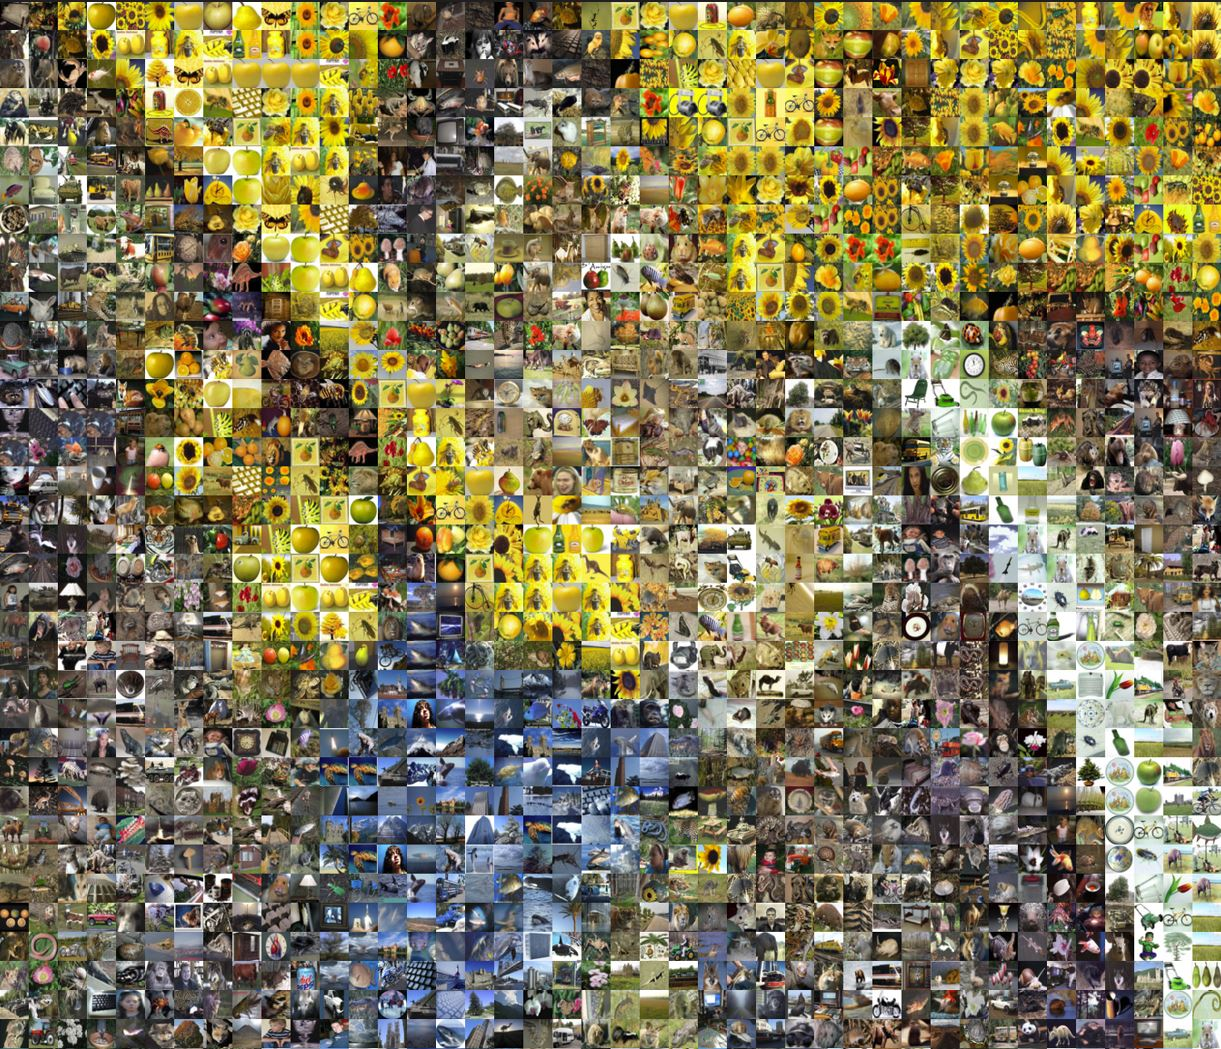

# Proposed algorithm
Algorithmically this is a hard task!
We will use an image with P = ~200'000 pixels in an image. But it could easily be millions or even billions of pixels.

And for each pixel we will have to find a matching image. We will use cifar10 for the tiles, so that T = 50'000 images. But it could easily be millions of images!

So a naive algorithm would have complexity $\Omega(PT)$ -- it's already terrible, but we haven't even considered that the tiles can be fairly large.

**What to do, what to do!?**

First, by input image I mean the single large-ish image we want to turn into a mosaic. By a tile I mean each of the many small images which will be the tiles of the resulting mosaic.

In our example the input is 512x512 and the tiles are 32x32. Both are RGB images.

Now, we will do a couple of tricks:
- To find the matching tile, we will consider its mean color and compare it with the pixel which it's meant to replace. We just reduced the dimensionality of our data from $32*32*3$ to $3$. And it makes sense here!

> It's useful to think of these RGB vectors as *fingerprints* of the images. They contain only the crucial data (in this case mean color), but make the search process much easier.

- Since now our data is now 3-dimensional, we can just use kd-trees to look for nearest neighbours!

> You should remember from our notebook that kd-trees are super efficient for low dimensions, but their performance totally degrades around d=100.

- So we will build a kd-tree on top of the mean-colors of tiles and query for each pixel in the input image. 

> Note that a single query returns an index of the nearest mean-color -- but that's also the index of the tile we want!

- So now we have an index of a tile for each pixel in the input image.

- The last step is to convery these indices to the final image -- that's just (no so) basic numpy.

# Some things to watch out for:
- Do *not* normalize the tiles, by dividing by 255. Keep the values as integers between 0 and 255. Note after loading cifar100 numpy represent each RGB intensity as a np.uint8 type. It only needs 1 byte of memory. A floating value uses 8 bytes. Normally it's not an issue, but we will generate very large images -- so if we use floats memory will likely blow up.

- The means can be stored as floats -- they don't take up too much space. So they should be *floats* between 0 and 255. 

- You can imshow a single color (RGB vector) by reshaping it into a vector with shape (1,1,3). 

- The hardest part is re-arranging the tiles in the correct order. It's not a simple reshape. The easy way of doing it, is to create a large empty np.array representing the ouput image -- and paste each tile in te appropriate place in it. Rembmer about the fancy indexing like: output[32:64, 64:96] = some_tile.

- A more advanced way would be to do an intricate usage of np.transpose and then np.reshape.

- Overall, the main algorthm can be done in 5 lines of code with no explicit loops.

- You can save the resulting nparray as an '.png' or '.jpg' image like this: Image.fromarray(result).save('out.png')

> The png version will be compressed losslessly and will look much better than jpg -- but the file may be huge! You can then download it and zoom in on your compute as I did in class.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from PIL import Image
import urllib.request
from keras.datasets import cifar100 as tiles_dataset

# Data loading

In [ ]:
def get_image(img_URL, w):
  '''Just downloads an image, feel free to use another url,
    but it has to point directly at an image file.
     Note that no normalization is performed.  
  '''  
  file_name = 'input_image_name_on_disk'
  urllib.request.urlretrieve(img_URL, file_name)
  im = Image.open(file_name)  
  im = im.resize((w,w))  
  return np.asarray(im)[..., :3]

In [ ]:
img_UF_URL = "http://people.clas.ufl.edu/hwagner/files/UF.png"
img_ravenna_URL = "http://people.clas.ufl.edu/hwagner/files/ravenna.jpg"
mos = get_image(img_UF_URL, w = 512)

In [ ]:
tiles = tiles_dataset.load_data()[0][0]

In [ ]:
mos.shape

(512, 512, 3)

In [ ]:
tiles = tiles_dataset.load_data()[0][0]

In [ ]:
tiles.shape

(50000, 32, 32, 3)

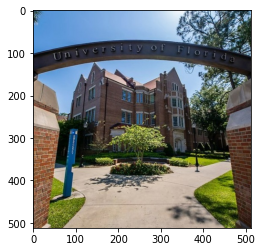

In [ ]:
plt.imshow(mos)

# Task 1: the proof-of-concept [weight ~0.2]
First, compute the mean colors of all the tiles and construct a kd-tree. 

Now generate 10 random colors and query the kd-tree for the nearest neighbours. For each of the 10 colors, imshow (in a horizontal row): the original color, the nearest mean color and the tile corresponding to the mean color.

> The results should make sense. Keep in mind that we're talking about the mean color. So something red on a which background will be pink on average!

In [ ]:
def plot_images_in_a_row(ims):    
  'Takes a list/array of images and plots them spaced horizontally.'
  _, axs = plt.subplots(1, len(ims), figsize = (20,5))
  for im, ax in zip(ims, axs.ravel()):
    ax.imshow(im)
    ax.axis('off')

In [ ]:
#compute mean color and generate mean colors
mean_color = np.mean(tiles[:,:,:,],axis = (1,2))
random_color = np.random.randint(0,255,(10,3))

In [ ]:
kd_tree = KDTree(mean_color) # construct the kd-tree 
inds = kd_tree.query(random_color, k=1, return_distance = False)

In [ ]:
#reshape in order to to plot
original_color = random_color.reshape(10,1,1,3)
nearest_mean = np.rint(mean_color[inds].reshape(10,1,1,3)).astype(int)
corr_tiles = tiles[inds].reshape(10,32,32,3)

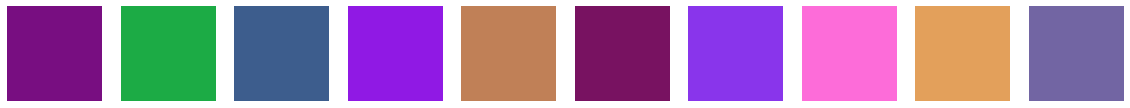

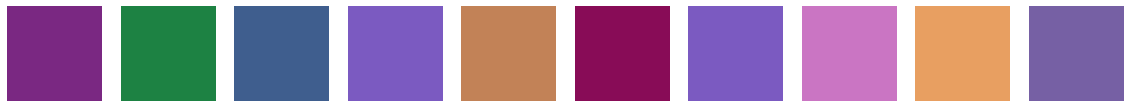

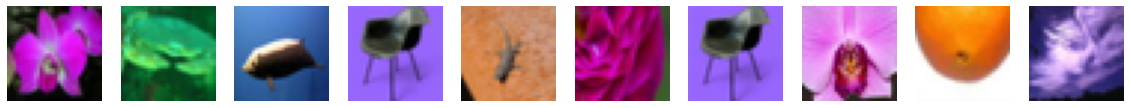

In [ ]:
plot_images_in_a_row(original_color)
plot_images_in_a_row(nearest_mean)
plot_images_in_a_row(corr_tiles)

# Task 2: the full-fledged implementation [weight ~0.7]

If everything looks good in task 1, we are ready for the full algorithm. Good luck!

In [ ]:
# your code
kd_tree = KDTree(mean_color) # construct the kd-tree 
inds = kd_tree.query(mos.reshape(512*512,3), k=1, return_distance = False)

In [ ]:
corr_tiles = tiles[inds].reshape(512*512,32,32,3)

In [ ]:
output = np.zeros((512*32,512*32,3))

In [ ]:
%%time
for i in range(512):
  for j in range(512):
    output[i*32:(i+1)*32, j*32:(j+1)*32] = corr_tiles[i*512+j,:,:,:]

CPU times: user 4.15 s, sys: 18.7 ms, total: 4.17 s
Wall time: 4.19 s


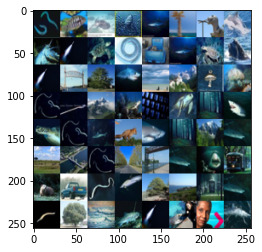

In [ ]:
plt.imshow(output[0:32*8,0:32*8].astype('uint8'))

In [ ]:
Image.fromarray(output.astype('uint8')).save('out.png')

In [ ]:
Image.MAX_IMAGE_PIXELS = 1000000000 

# Task 3: Validation [weight ~0.1]

Imshow the portion of the ouput image (numpy array) which corresponds to the top-left 8x8 tiles. 

Below is what I got. If you look at your output and my output and the results are visually the same -- well done! 

> If you get something different here, you may have used some slight variation of the algorithm. Ideally try to get the same results, since it will make grading much easier.

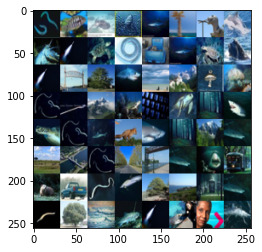

In [ ]:
plt.imshow(output[0:32*8,0:32*8].astype('uint8'))

Yes, I did get the same image

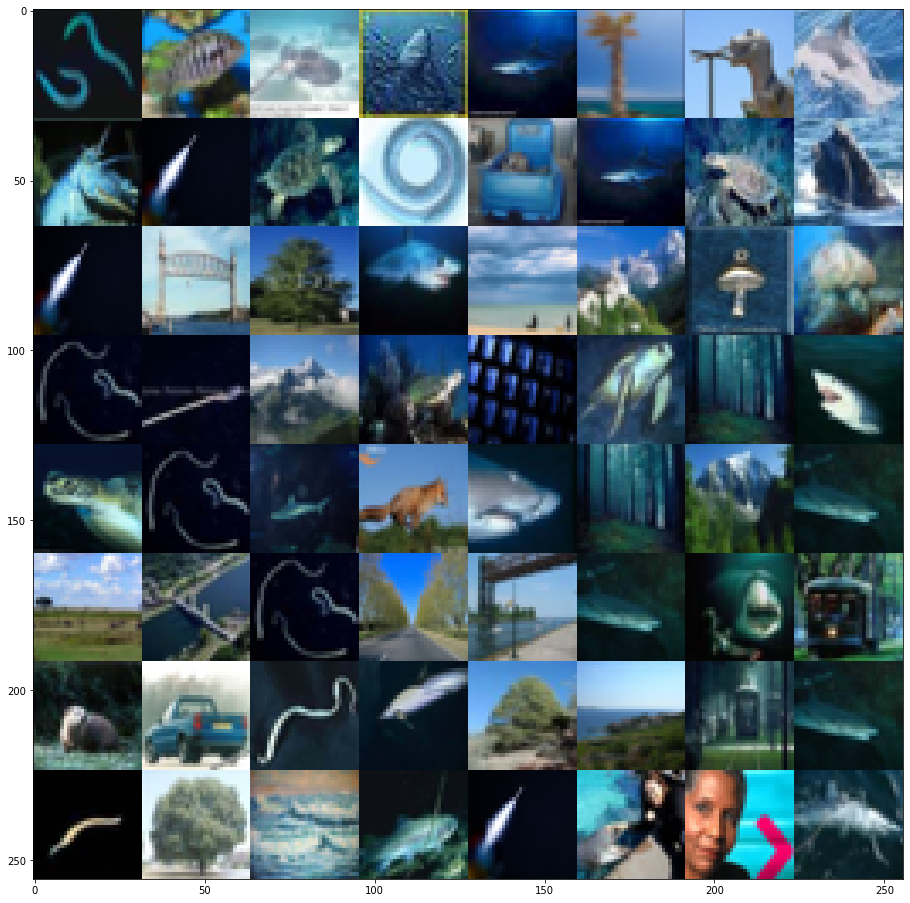

# Bonus [some extra credit, could be a lot if you do something interesting]:
Try to improve this method. If you managed to do someting interesting -- show how the versions compare. Maybe plot the same portions of the mosaic side by side?

- One shortcoming is that we will often get patches of similar images -- can we do something about this in an elegant way? Can you implement this version and compare the results?

- Maybe just taking the mean color is not what we really want? I mean the idea is that the derived color kind of corresponds to how we percieve a tile from afar. Can you propose and test and alternative approach?

- Maybe taking the means loses too much information. Can you try a more fine-grained fingerprint?

- Maybe using the Euclidean distance is not the best way to compare colors? Can you try out some variation?

> An extreme version of this problem is an 'infinite zoom' version done in real-time. So as you keep zooming in the pixels of the tiles would be revealed to be images -- and you could zoom in like that forever. I've never impleented this, but I suspect it's actually feasibly on moderns GPU (similar data-structures are used for raytracing). Maybe some of you have  thoughts on this.